# Label Free Quantification - LFQ (DDA)

This tutorial demonstrates how to analyze label-free quantification (LFQ) data using the `msmu` package. We will cover data reading, preprocessing, normalization.

## Data Preparation

Original dataset is from [PXD012986](https://www.ebi.ac.uk/pride/archive/projects/PXD012986) (Uszkoreit et al., 2022) and search was performed with [Sage v0.14.7](https://github.com/lazear/sage/tree/v0.14.7).

Example dataset was modified to include only 6 samples total with only 5000 psms.


In [1]:
!wget https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/sage_lfq/sage/lfq.tsv
!wget https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/sage_lfq/sage/results.sage.tsv
!wget https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/sage_lfq/meta.csv

--2025-11-25 19:18:09--  https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/sage_lfq/sage/lfq.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 845778 (826K) [text/plain]
Saving to: ‘lfq.tsv.1’

lfq.tsv.1           100%[===================>] 825.96K  --.-KB/s    in 0.01s   

2025-11-25 19:18:09 (74.1 MB/s) - ‘lfq.tsv.1’ saved [845778/845778]

--2025-11-25 19:18:09--  https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/sage_lfq/sage/results.sage.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respons

## Load Required Packages

> If you haven't installed the `msmu` package yet, please follow the [installation guide](../../installation/).


In [2]:
import msmu as mm
import pandas as pd
import plotly.io as pio

pio.renderers.default = "png"

## Read Data

You can read data from various proteomics software outputs. Below are examples for Sage, MaxQuant, and FragPipe formats.

For this tutorial, we will use the Sage output as an example.

`read_sage()` function reads the Sage output files (`lfq.tsv`, `results.sage.tsv`) and creates modalities at Mudata object.


In [3]:
# Sage format
mdata = mm.read_sage(".", label="label_free")

# MaxQuant format
# mdata = mm.read_maxquant("path_to_maxquant_directory/", label="label_free")

# FragPipe format
# mdata = mm.read_fragpipe("path_to_fragpipe_directory/", label="label_free")

INFO - Feature file loaded: (5000, 40)
INFO - Quantification file loaded: (3578, 12)


INFO - Decoy entries separated: (345, 13)


In [4]:
mdata

MuData object with n_obs × n_vars = 6 × 8233
  2 modalities
    feature:	6 x 4655
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'search_output_dir', 'search_config', 'decoy'
      varm:	'search_result'
    peptide:	6 x 3578
      uns:	'level'

### Adding Metadata

Optionally, you can add metadata for samples to the `mdata.obs` dataframe. Make sure that the index of the metadata dataframe matches the sample names in `mdata.obs`.


In [5]:
meta_df = pd.read_csv("meta.csv")
meta_df = meta_df.set_index("sample_id")  # set the index to match sample id in mdata.obs

mdata.obs = mdata.obs.join(meta_df)
mdata.push_obs()  # push the updated obs back to the MuData object
mdata.obs

,set,sample_name,condition,replicate
QExHF04026,S1,G1-1,G1,1
QExHF04028,S1,G2-1,G2,1
QExHF04036,S1,G1-2,G1,2
QExHF04038,S1,G2-2,G2,2
QExHF04046,S1,G1-3,G1,3
QExHF04048,S1,G2-3,G2,3


## Filter features

You can filter features based on q-value. If needed, you can also remove contaminants.

Filtering is split into two steps: first, you mark a filter condition using `mm.pp.add_filter()`, and then you apply the filter using `mm.pp.apply_filter()`.


In [6]:
# Mark filter conditions
mdata = mm.pp.add_filter(mdata, modality="feature", column="q_value", keep="lt", value=0.01)
# mdata = mm.pp.add_filter(mdata, modality="feature", column="proteins", keep="not contains", value="contam_")

# Apply filters
mdata = mm.pp.apply_filter(mdata, modality="feature")
mdata

MuData object with n_obs × n_vars = 6 × 7914
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  2 modalities
    feature:	6 x 4336
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'search_output_dir', 'search_config', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 3578
      obs:	'set', 'sample_name', 'condition', 'replicate'
      uns:	'level'

## Handling peptide level

You can summarise psm-level data to peptide-level data using the `mm.pp.to_peptide()` function.

Followed by summarisation, data processing at the peptide level includes filtering, log2 transformation, and normalisation.


In [7]:
# Summarise to peptide
mdata = mm.pp.to_peptide(mdata)

# Filter peptides based on q-value
mdata = mm.pp.add_filter(mdata, modality="peptide", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="peptide")

# Log2 transform the data
mdata = mm.pp.log2_transform(mdata, modality="peptide")

# Normalize the data using median centering normalization
mdata = mm.pp.normalise(mdata, modality="peptide", method="median")

INFO - Peptide-level identifications: 3683 (3664 at 1% FDR)


Using existing peptide quantification data.


In [8]:
mdata

MuData object with n_obs × n_vars = 6 × 8000
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  2 modalities
    feature:	6 x 4336
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'search_output_dir', 'search_config', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 3664
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

### Protein inference

You can infer protein-level data from peptide-level data using the `mm.pp.infer_protein()` function.


In [9]:
# Protein group inference with peptides and their matched proteins
mdata = mm.pp.infer_protein(mdata)

INFO - Starting protein group inference
INFO - Initial proteins: 3721
INFO - Removed indistinguishable: 1624
INFO - Removed subsettable: 559
INFO - Removed subsumable: 2
INFO - Total protein groups: 1536


## Handling protein level

You can summarise peptide-level data to protein-level data using the `mm.pp.to_protein()` function.

Followed by summarisation, filtering q-value is performed at the protein level.


In [10]:
# Summarise to protein
# Top 3 peptides wihin protein group can be used for protein group quantification aggregation; if top_n is None, all peptides will be used.
mdata = mm.pp.to_protein(mdata, top_n=3, rank_method="total_intensity")

# Filter protein groups based on q-value:
mdata = mm.pp.add_filter(mdata, modality="protein", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="protein")

INFO - Ranking features by 'total_intensity' to select top 3 features.
INFO - Protein-level identifications :  1501 (1475 at 1% FDR)


In [11]:
mdata

MuData object with n_obs × n_vars = 6 × 9475
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  3 modalities
    feature:	6 x 4336
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'search_output_dir', 'search_config', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 3664
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value', 'protein_group', 'peptide_type'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'
    protein:	6 x 1475
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

## Visualisation

### ID plot


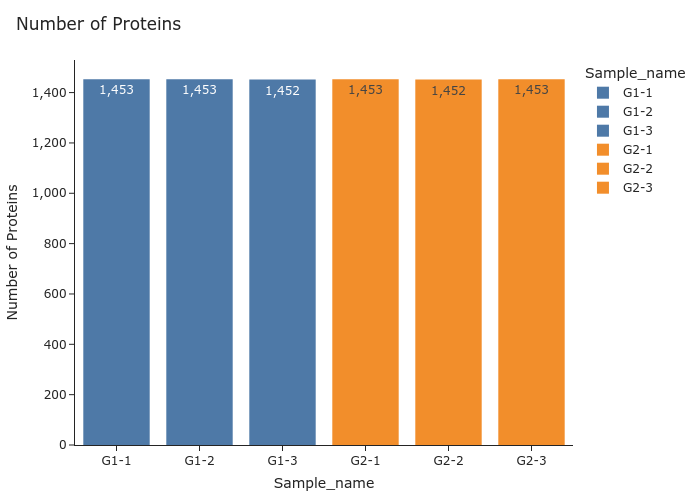

In [12]:
mm.pl.plot_id(mdata, modality="protein", colorby="condition", obs_column="sample_name")

### Intensity distribution plot


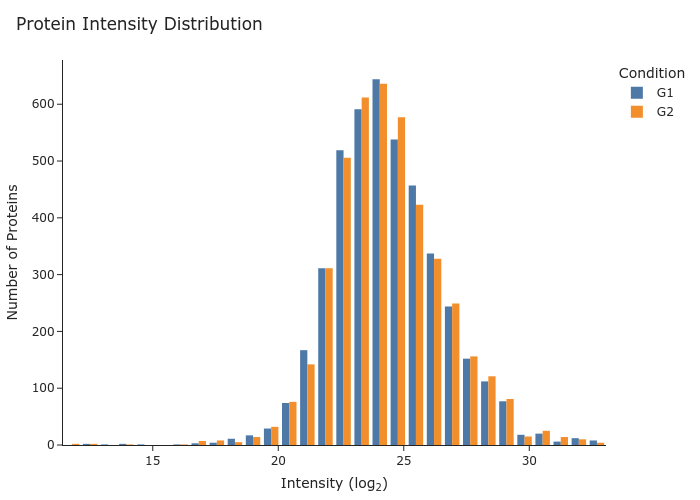

In [13]:
mm.pl.plot_intensity(mdata, modality="protein", groupby="condition", obs_column="sample_name")

## Citation

> Uszkoreit, J., Barkovits, K., Pacharra, S., Pfeiffer, K., Steinbach, S., Marcus, K., & Eisenacher, M. (2022). Dataset containing physiological amounts of spike-in proteins into murine C2C12 background as a ground truth quantitative LC-MS/MS reference. Data in Brief, 43, 108435.

> Lazear, M. R. (2023). Sage: an open-source tool for fast proteomics searching and quantification at scale. Journal of Proteome Research, 22(11), 3652-3659.
